# REFUGE Multi Class Semantic Segmentation

In [1]:
import numpy as np
import pandas as pd
from keras.utils import normalize
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sys
print(sys.version)
print(tf.__version__)

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
2.13.0


# Data Preprocessing

## Training Data

In [3]:
SIZE = 256

In [4]:
train_image_directory = glob.glob("/kaggle/input/refuge-train-test/REFUGE Train Test/train/images/*.jpg")
train_image_directory.sort()
train_mask_directory = glob.glob("/kaggle/input/refuge-train-test/REFUGE Train Test/train/gts/*.bmp")
train_mask_directory.sort()

In [5]:
len(train_image_directory), len(train_mask_directory)

(600, 600)

In [6]:
# Initialize empty list to store data
train_images = []
train_masks = []

In [7]:
# Read and preprocess each image
for image_name in train_image_directory:
    # Read image in RGB format
    image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    # Resize image
    image = cv2.resize(image, (SIZE, SIZE))
    # Rescale image
    image = image/255.0
    # Append image
    train_images.append(image)

In [8]:
len(train_images)

600

In [9]:
train_images = np.array(train_images)

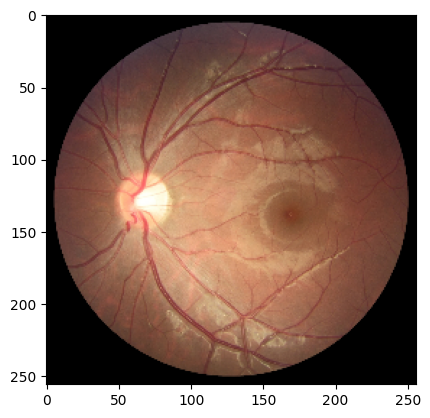

In [10]:
plt.imshow(train_images[0])

In [11]:
# Read and preprocess each mask
for mask_name in train_mask_directory:
    # Read mask in grayscale format
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    # Resize mask
    mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
    # Rescale mask
    mask = mask/255.0
    # Expand Dimensions
    mask = np.expand_dims(mask,axis=-1)
    # Append mask
    train_masks.append(mask)

In [12]:
len(train_masks)

600

In [13]:
train_masks = np.array(train_masks)

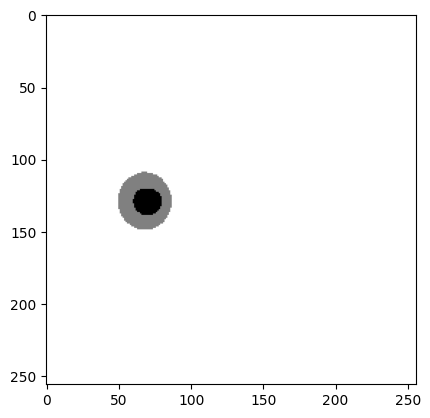

In [14]:
plt.imshow(train_masks[0], cmap='gray')

In [15]:
train_images.shape, train_masks.shape

((600, 256, 256, 3), (600, 256, 256, 1))

In [16]:
np.unique(train_masks)

array([0.        , 0.50196078, 1.        ])

In [17]:
train_images.dtype, train_masks.dtype

(dtype('float64'), dtype('float64'))

In [18]:
train_masks = train_masks.astype(np.float32)

In [19]:
train_masks.shape, train_masks.dtype

((600, 256, 256, 1), dtype('float32'))

In [20]:
np.unique(train_masks)

array([0.       , 0.5019608, 1.       ], dtype=float32)

## Testing Data

In [21]:
test_image_directory = glob.glob("/kaggle/input/refuge-train-test/REFUGE Train Test/test/images/*.jpg")
test_image_directory.sort()
test_mask_directory = glob.glob("/kaggle/input/refuge-train-test/REFUGE Train Test/test/gts/*.bmp")
test_mask_directory.sort()

In [22]:
# Initialize empty list to store data
test_images = []
test_masks = []

In [23]:
# Read and preprocess each image
for image_name in test_image_directory:
    # Read image in RGB format
    image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    # Resize image
    image = cv2.resize(image, (SIZE, SIZE))
    # Rescale image
    image = image/255.0
    # Append image
    test_images.append(image)

In [24]:
len(test_images)

600

In [25]:
test_images = np.array(test_images)

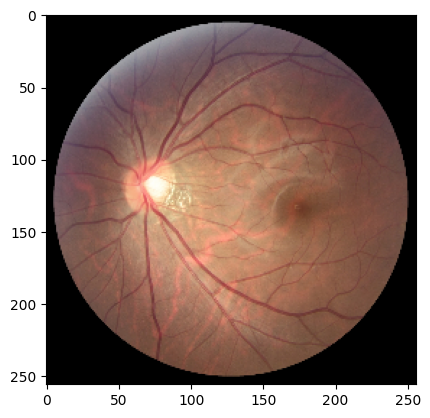

In [26]:
plt.imshow(test_images[0])

In [27]:
# Read and preprocess each mask
for mask_name in test_mask_directory:
    # Read mask in grayscale format
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    # Resize mask
    mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
    # Rescale mask
    mask = mask/255.0
    # Expand Dimensions
    mask = np.expand_dims(mask,axis=-1)
    # Append mask
    test_masks.append(mask)

In [28]:
len(test_masks)

600

In [29]:
test_masks = np.array(test_masks)

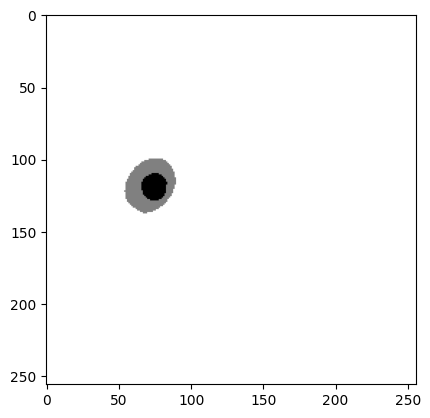

In [30]:
plt.imshow(test_masks[0], cmap='gray')

In [31]:
np.unique(test_masks)

array([0.        , 0.50196078, 1.        ])

In [32]:
test_images.shape, test_masks.shape

((600, 256, 256, 3), (600, 256, 256, 1))

In [33]:
test_images.dtype, test_masks.dtype

(dtype('float64'), dtype('float64'))

In [34]:
test_masks = test_masks.astype(np.float32)

In [35]:
test_masks.shape, test_masks.dtype

((600, 256, 256, 1), dtype('float32'))

In [36]:
np.unique(test_masks)

array([0.       , 0.5019608, 1.       ], dtype=float32)

## Shapes and Data-types of all Objects Created so far

In [37]:
train_images.shape, train_masks.shape, test_images.shape, test_masks.shape

((600, 256, 256, 3),
 (600, 256, 256, 1),
 (600, 256, 256, 3),
 (600, 256, 256, 1))

In [38]:
train_images.dtype, train_masks.dtype, test_images.dtype, test_masks.dtype

(dtype('float64'), dtype('float32'), dtype('float64'), dtype('float32'))

## Visualize Images and Corresponding Masks

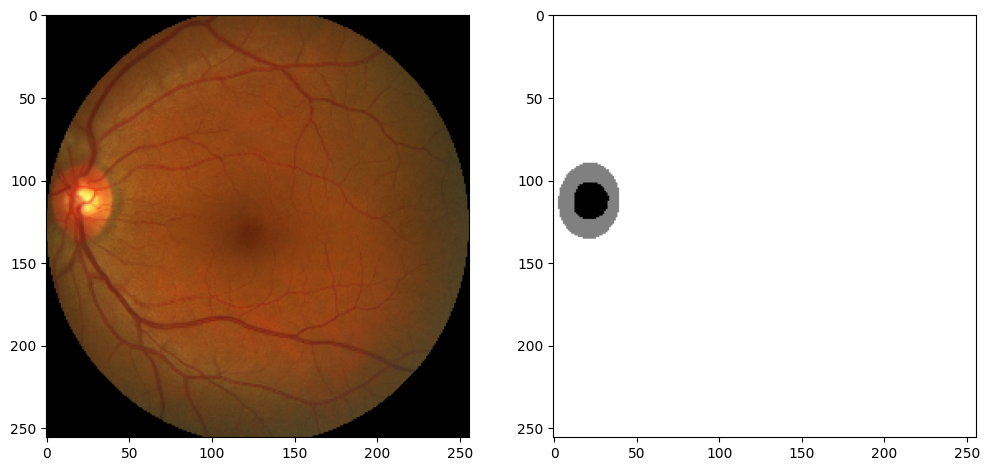

In [39]:
image_number = random.randint(0, len(train_images))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(train_images[image_number])
plt.subplot(122)
plt.imshow(train_masks[image_number], cmap='gray')
plt.show()

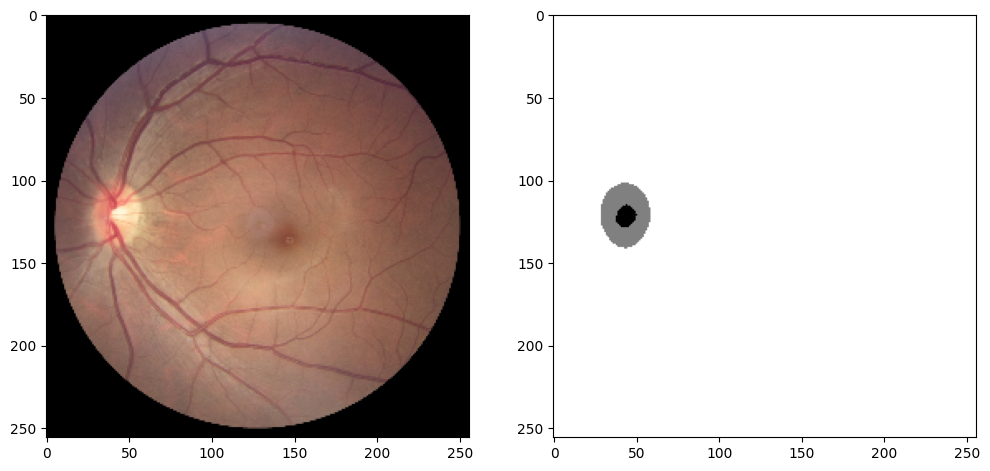

In [40]:
image_number = random.randint(0, len(test_images))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(test_images[image_number])
plt.subplot(122)
plt.imshow(test_masks[image_number], cmap='gray')
plt.show()

## Label Encoding of Masks

### Train Masks

In [41]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [42]:
a, n, h, w = train_masks.shape

In [43]:
train_masks_reshaped = train_masks.reshape(-1,1)

In [44]:
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(a,n,h,w)

In [46]:
train_masks_encoded_original_shape.shape

(600, 256, 256, 1)

In [47]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2])

### Test masks

In [48]:
a, n, h, w = test_masks.shape

In [49]:
test_masks_reshaped = test_masks.reshape(-1,1)

In [50]:
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(a,n,h,w)

In [52]:
test_masks_encoded_original_shape.shape

(600, 256, 256, 1)

In [53]:
np.unique(test_masks_encoded_original_shape)

array([0, 1, 2])

## Masks Conversion into Categorical

In [54]:
from keras.utils import to_categorical

In [55]:
train_masks_categorical = to_categorical(train_masks_encoded_original_shape, num_classes=3)

In [56]:
test_masks_categorical = to_categorical(test_masks_encoded_original_shape, num_classes=3)

In [57]:
train_masks_categorical.shape, test_masks_categorical.shape

((600, 256, 256, 3), (600, 256, 256, 3))

In [58]:
train_masks_categorical.dtype, test_masks_categorical.dtype

(dtype('float32'), dtype('float32'))

## Defining X_train, X_test, y_train and y_test

In [59]:
# X refers to Images
X_train = train_images
X_test = test_images
# y refers to Masks
y_train = train_masks_categorical
y_test = test_masks_categorical

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 256, 256, 3),
 (600, 256, 256, 3),
 (600, 256, 256, 3),
 (600, 256, 256, 3))

# Evaluation Metrics for Multi Class Semantic Segmentation

In [61]:
from tensorflow.keras import backend as K
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]

# U-Net based models for OC/OD Segmentation

In [62]:
pip install segmentation_models

  Obtaining dependency information for segmentation_models from https://files.pythonhosted.org/packages/da/b9/4a183518c21689a56b834eaaa45cad242d9ec09a4360b5b10139f23c63f4/segmentation_models-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for keras-applications<=1.0.8,>=1.0.7 from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for image-classifiers==1.0.0 from https://files.pythonhosted.org/packages/81/98/6f84720e299a4942ab80df5f76ab97b7828b24d1de5e9b2cbbe6073228b7/image_classifiers-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for efficientnet==1.0.0 from https://files.pythonhosted.org/packages/97/82/f3ae07316f0461417dc54affab6e86ab188a5a22f33176d35271628b96e0/efficientnet-1.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00
Note: you may need to

In [63]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [64]:
pip install keras-unet-collection

  Obtaining dependency information for keras-unet-collection from https://files.pythonhosted.org/packages/a4/1f/5b17d50b28ffd81f39ebf5a2a85466517bd39375a47347cfd95547db58ab/keras_unet_collection-0.1.13-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [65]:
from keras_unet_collection import models

# CSP-SegNet

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import *
import keras
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

## Inverted Residual Block

In [72]:
def inverted_residual_block(inputs, num_filters, strides=1, expansion_ratio=1):
    # point-wise conv
    x = Conv2D(filters=expansion_ratio*inputs.shape[-1],
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    # depth-wise conv
    x = DepthwiseConv2D(kernel_size=3,
                          strides=strides,
                          padding='same',
                          use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    
    # point-wise conv
    x = Conv2D(filters=num_filters,
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # Residual Connection
    if strides == 1 and (inputs.shape == x.shape):
        return Add()([inputs, x])
    return x

## Channel and Spatial Attention Modules

In [75]:
class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(16, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv4 = tf.keras.layers.Conv2D(1, kernel_size=kernel_size,  
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)
    

class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = tf.keras.layers.GlobalAveragePooling2D()
        self.gmpmax = tf.keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1]//self.ratio, 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
    
        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1], 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = tf.keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = tf.keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(self.conv1(gapavg))
        gmpmax_out = self.conv2(self.conv1(gmpmax))
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

## Pixel Attention

In [76]:
def pixel_attention(x, nf):
    # Assuming input_features shape: (batch_size, height, width, channels)
    
    # Apply convolution to capture spatial dependencies
    conv = tf.keras.layers.Conv2D(nf, 3, padding='same', activation='relu')(x)
    
    # Apply convolution to obtain attention scores
    attention_scores = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(conv)
    
    # Multiply attention scores with input features
    weighted_features = tf.multiply(x, attention_scores)
    
    return weighted_features

## Squeeze and Excitation Block

In [77]:
def se_block(tensor, ratio):
    nb_channel = K.int_shape(tensor)[-1]

    x = GlobalAveragePooling2D()(tensor)
    x = Dense(nb_channel // ratio, activation='relu')(x)
    x = Dense(nb_channel, activation='sigmoid')(x)

    x = Multiply()([tensor, x])
    return x

## CSP Attention Module

In [78]:
def csp_module(x, nf):
    x_pa = pixel_attention(x, nf)
    
    x_ca = ChannelAttentionModule()(x)
    
    x_sa = SpatialAttentionModule()(x)
    
    x_casa = Multiply()([x_sa, x_ca])
    
    x_out = Concatenate()([x_casa, x_pa])
    return x_out

# CSP-SegNet Model

In [79]:
# Input Layer
inputs = tf.keras.layers.Input((256,256,3))

# Downsampling
x = SeparableConv2D(32, (3,3), padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x1 = inverted_residual_block(x, num_filters=32)

x1_csp = csp_module(x1, 32) 

x = MaxPooling2D((2,2))(x1)

x = SeparableConv2D(64, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x2 = inverted_residual_block(x, num_filters=64)

x2_csp = csp_module(x2, 64) 

x = MaxPooling2D((2,2))(x2)

x = SeparableConv2D(128, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x3 = inverted_residual_block(x, num_filters=128)

x3_csp = csp_module(x3, 128) 

x = MaxPooling2D((2,2))(x3)

x = SeparableConv2D(256, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x4 = inverted_residual_block(x, num_filters=256)

x4_csp = csp_module(x4, 256)

x = MaxPooling2D((2,2))(x4)

# Upsampling

x = UpSampling2D(interpolation="bilinear")(x)
x = Concatenate()([x, x4_csp])

x = SeparableConv2D(256, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x = SeparableConv2D(256, (1,1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(interpolation="bilinear")(x)
x = Concatenate()([x, x3_csp])

x = SeparableConv2D(128, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x = SeparableConv2D(128, (1,1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(interpolation="bilinear")(x)
x = Concatenate()([x, x2_csp])

x = SeparableConv2D(64, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)

x = SeparableConv2D(64, (1,1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(interpolation="bilinear")(x)
x = Concatenate()([x, x1_csp])

x = SeparableConv2D(32, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = se_block(x, 16)


x = SeparableConv2D(3, (1,1), activation='softmax')(x)

In [80]:
CSP_UNet = keras.Model(inputs, x)

In [81]:
CSP_UNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 256, 256, 32)         155       ['input_3[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization_6 (Bat  (None, 256, 256, 32)         128       ['separable_conv2d[0][0]']    
 chNormalization)                                                                                 
                                                                                            

In [82]:
LR = 0.001
optimizer = tf.keras.optimizers.Adam(LR)
metrics =  [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),sm.metrics.IOUScore(), sm.metrics.FScore()]     
dice_loss = sm.losses.DiceLoss()
iou_loss = sm.losses.JaccardLoss()
total_loss = dice_loss+iou_loss

In [83]:
filepath = "/kaggle/working/unet.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_iou_score",
                             verbose=1, save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [84]:
#model.compile(optimizer=optimizer,loss=dice_loss,metrics = metrics)

In [85]:
CSP_UNet.compile(optimizer=optimizer,loss=dice_loss,metrics = metrics)

In [86]:
#CSP_UNet.run_eagerly = False

## CSP-Res-Seg-Net Model Training

In [87]:
history=CSP_UNet.fit(X_train, 
          y_train,
          callbacks=callbacks,
          batch_size=16, 
          epochs=60,
          validation_data=(X_test, y_test))

Epoch 1/60
38/38 [==============================] - ETA: 0s - loss: 0.7901 - precision: 0.7495 - recall: 0.0111 - iou_score: 0.1421 - f1-score: 0.2102
Epoch 1: val_iou_score improved from -inf to 0.12462, saving model to /kaggle/working/unet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 66s 693ms/step - loss: 0.7901 - precision: 0.7495 - recall: 0.0111 - iou_score: 0.1421 - f1-score: 0.2102 - val_loss: 0.8138 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou_score: 0.1246 - val_f1-score: 0.1862
Epoch 2/60
38/38 [==============================] - ETA: 0s - loss: 0.7540 - precision: 0.9664 - recall: 0.1546 - iou_score: 0.1732 - f1-score: 0.2463
Epoch 2: val_iou_score improved from 0.12462 to 0.13634, saving model to /kaggle/working/unet.h5
38/38 [==============================] - 19s 509ms/step - loss: 0.7540 - precision: 0.9664 - recall: 0.1546 - iou_score: 0.1732 - f1-score: 0.2463 - val_loss: 0.8014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou_score: 0.1363 - val_f1-score: 0.1986
Epoch 3/60
38/38 [==============================] - ETA: 0s - loss: 0.7120 - precision: 0.9938 - recall: 0.9573 - iou_score: 0.2139 - f1-score: 0.2884
Epoch 3: val_iou_score improved from 0.13634 to 0.15612, saving model

# Performance Evaluation

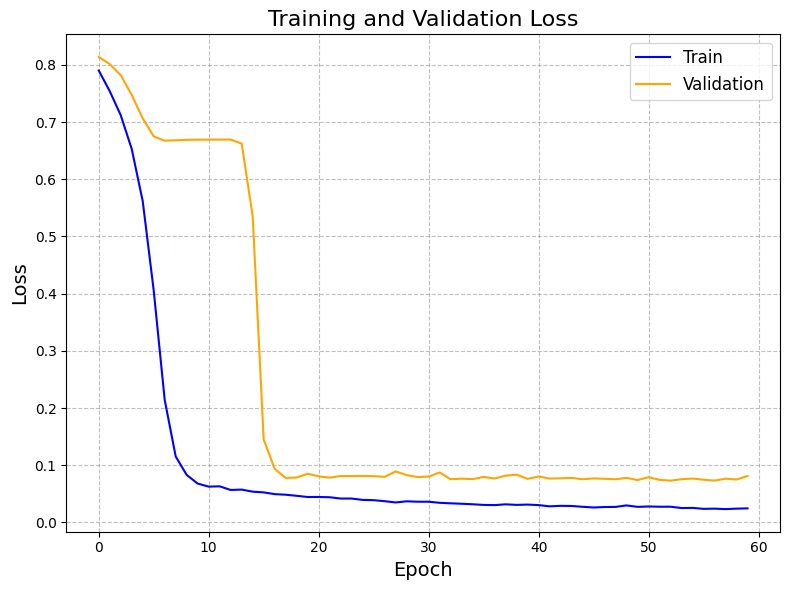

In [107]:
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(history.history['loss'], linestyle='-', color='blue', label='Train')  # Adjust line color
plt.plot(history.history['val_loss'], linestyle='-', color='orange', label='Validation')  # Adjust line color
plt.title('Training and Validation Loss', fontsize=16)  # Increase title font size
plt.xlabel('Epoch', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Loss', fontsize=14)  # Increase y-axis label font size
plt.legend(loc='upper right', fontsize=12)  # Adjust legend location and font size
plt.grid(True, linestyle='--', alpha=0.5, color='gray')  # Add gridlines with a dashed style
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('CSP-Res-Seg-Net.png', dpi=1200)
plt.show()

In [89]:
model = tf.keras.models.load_model('/kaggle/working/unet.h5',
                                  custom_objects={'ChannelAttentionModule':ChannelAttentionModule,
                                                'SpatialAttentionModule':SpatialAttentionModule,
                                                 'dice_loss':sm.losses.DiceLoss(),
                                                 'iou_score':sm.metrics.IOUScore(),
                                                 'f1-score':sm.metrics.FScore()})
                                

In [90]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test, y_test)

19/19 [==============================] - 10s 334ms/step - loss: 0.0731 - precision: 0.9975 - recall: 0.9975 - iou_score: 0.8683 - f1-score: 0.9269


In [91]:
# Print the evaluation results
print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, evaluation):
    print(f"{metric_name}: {metric_value}")

Evaluation Results:
loss: 0.07309131324291229
precision: 0.997506320476532
recall: 0.9975059032440186
iou_score: 0.8682506680488586
f1-score: 0.9268712401390076


In [92]:
# Make predictions on the test data
predicted_masks = model.predict(X_test)

# Separate the predicted masks into OC and OD
oc_predicted_masks = predicted_masks[:, :, :, 0]  # Assuming OC is the first channel
od_predicted_masks = predicted_masks[:, :, :, 1]  # Assuming OD is the second channel

# Calculate the individual losses for OC and OD
oc_loss = dice_loss(y_test[:, :, :, 0], oc_predicted_masks)
od_loss = dice_loss(y_test[:, :, :, 1], od_predicted_masks)

print("OC Loss:", oc_loss.numpy())
print("OD Loss:", od_loss.numpy())

19/19 [==============================] - 5s 201ms/step
OC Loss: 0.11471683
OD Loss: 0.10364413


In [93]:
# Calculate the individual dice scores for OC and OD
oc_dice = dice_coef(y_test[:, :, :, 0], oc_predicted_masks)
od_dice = dice_coef(y_test[:, :, :, 1], od_predicted_masks)

print("OC Dice:", oc_dice.numpy())
print("OD Dice:", od_dice.numpy())

OC Dice: 0.8852832
OD Dice: 0.8963559


In [94]:
# Calculate the individual IoU for OC and OD
oc_iou = sm.metrics.IOUScore()(y_test[:, :, :, 0], oc_predicted_masks)
od_iou = sm.metrics.IOUScore()(y_test[:, :, :, 1], od_predicted_masks)

print("OC IoU:", oc_iou.numpy())
print("OD IoU:", od_iou.numpy())

OC IoU: 0.79417783
OD IoU: 0.81217843


19/19 [==============================] - 4s 201ms/step


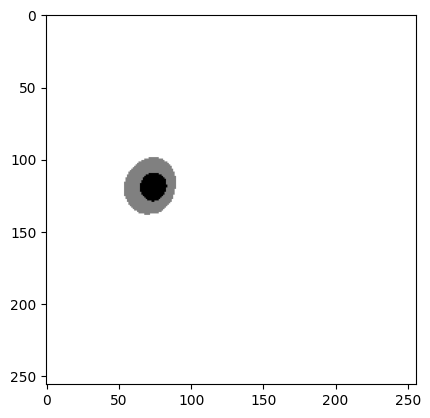

In [95]:
test_preds = model.predict(X_test)
preds_test_thresh = (np.argmax(test_preds,axis=-1)).astype(np.uint8)
test_img = preds_test_thresh[0, :, :]
plt.imshow(test_img, cmap='gray')

/tmp/ipykernel_47/905971323.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_47/905971323.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_47/905971323.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_47/905971323.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_47/905971323.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping 

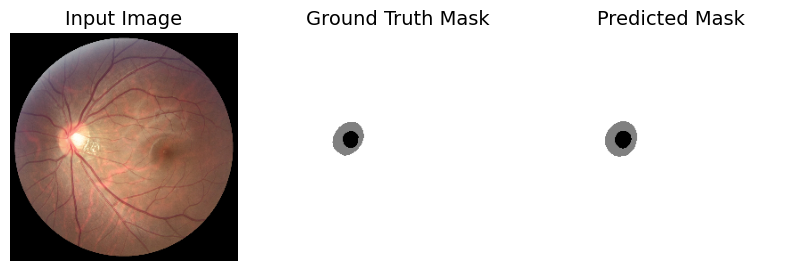

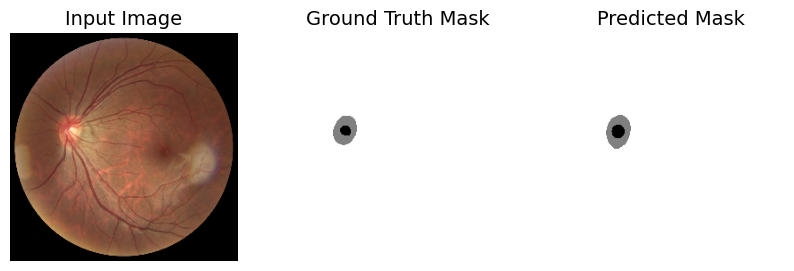

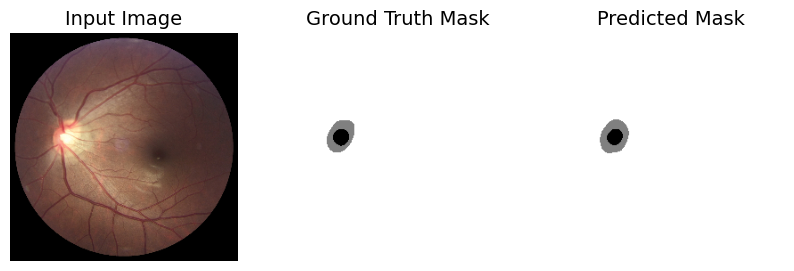

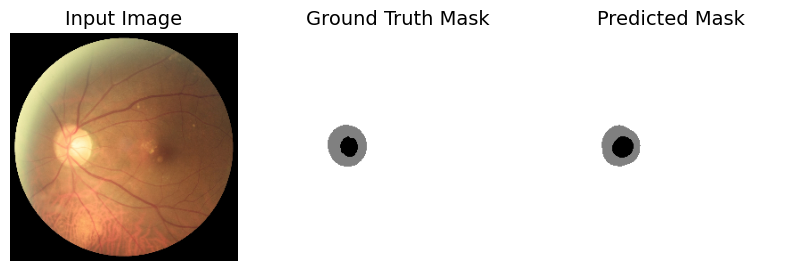

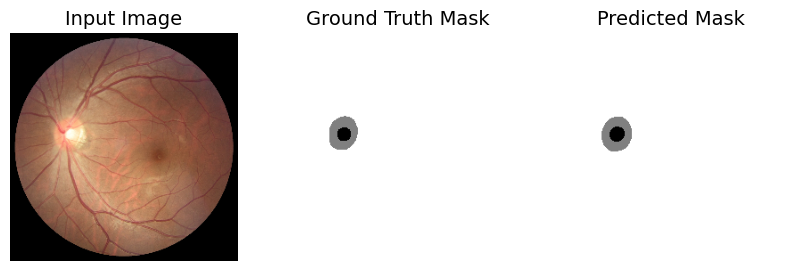

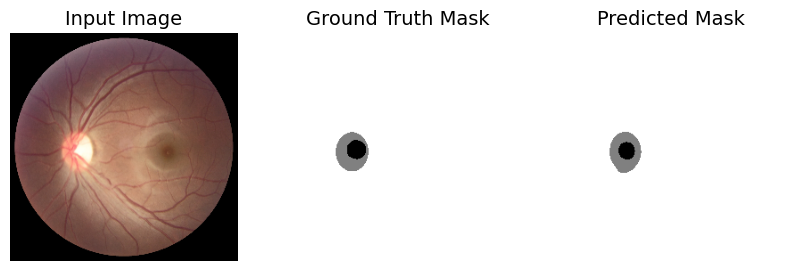

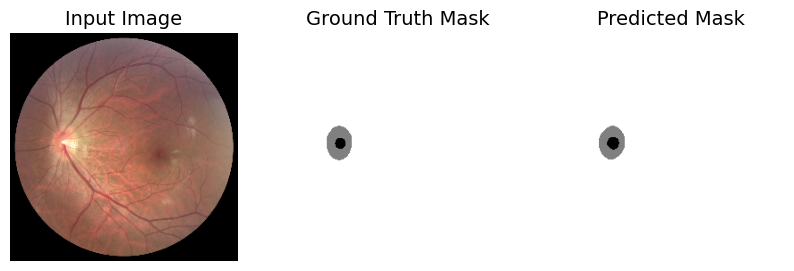

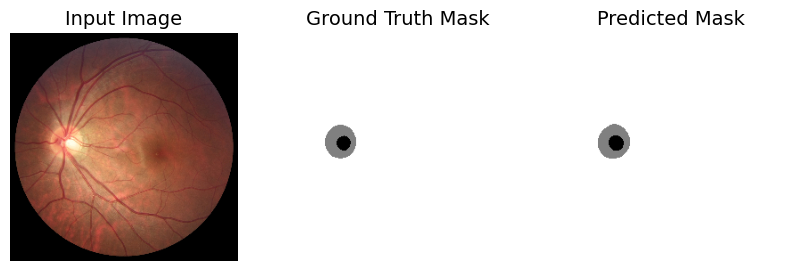

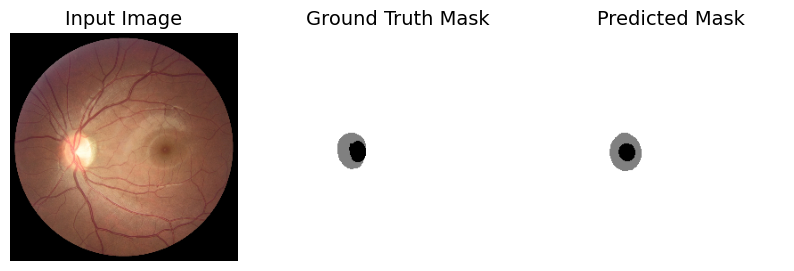

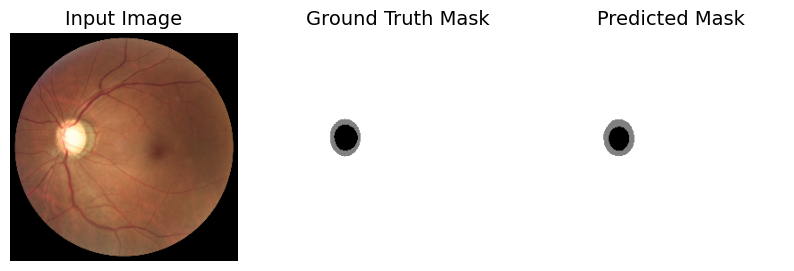

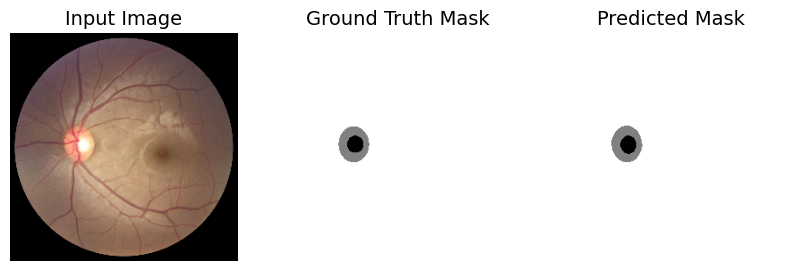

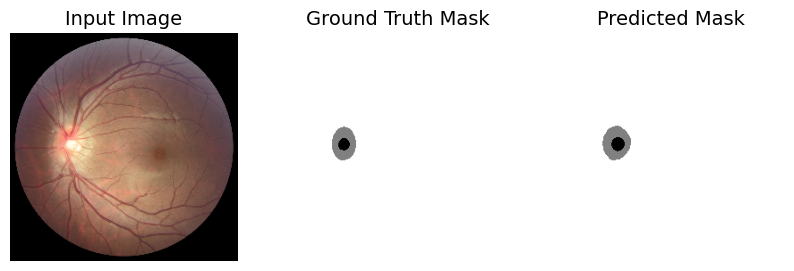

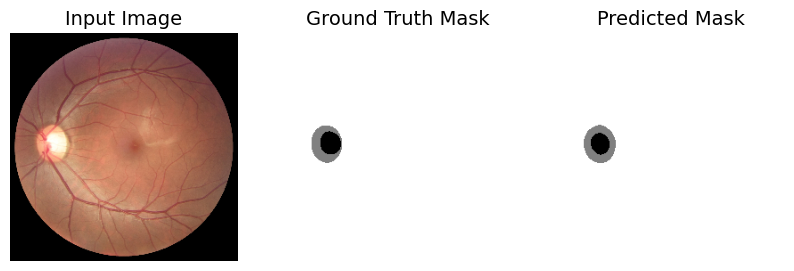

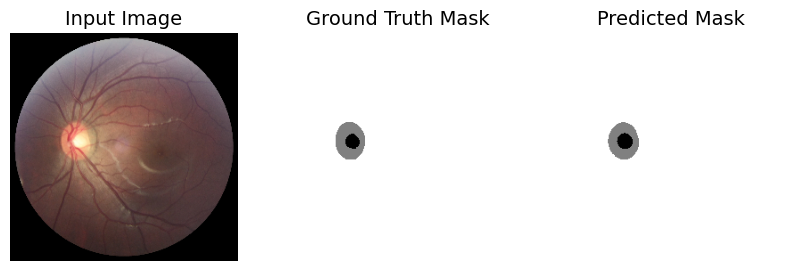

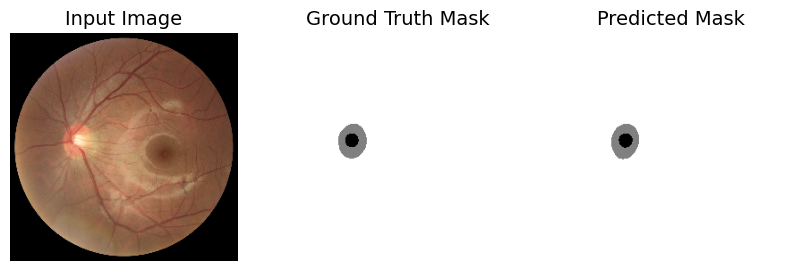

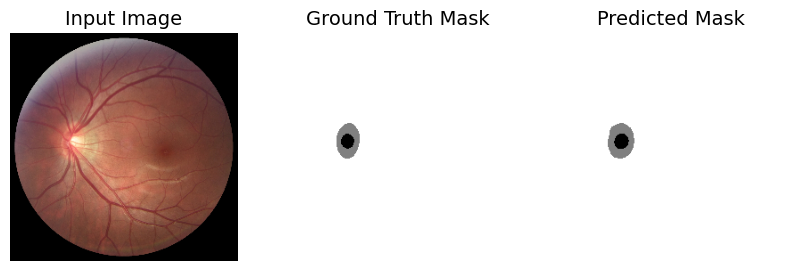

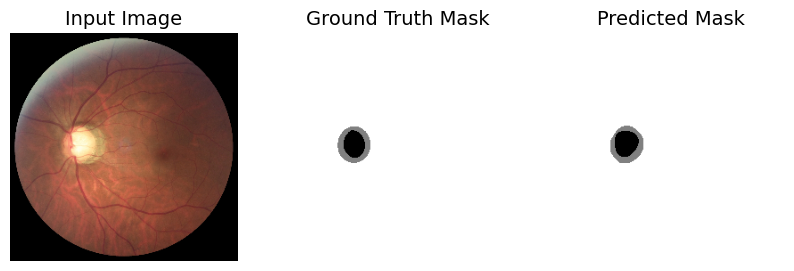

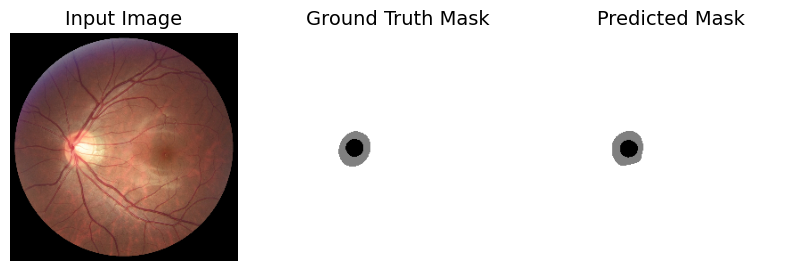

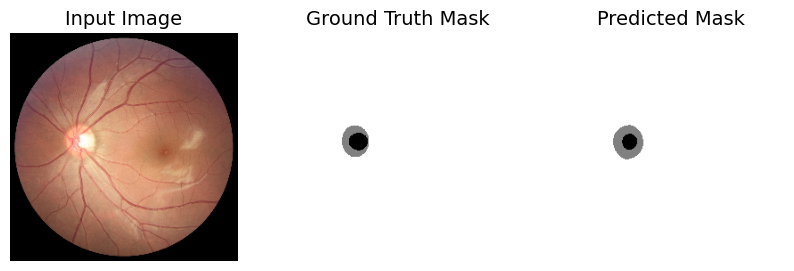

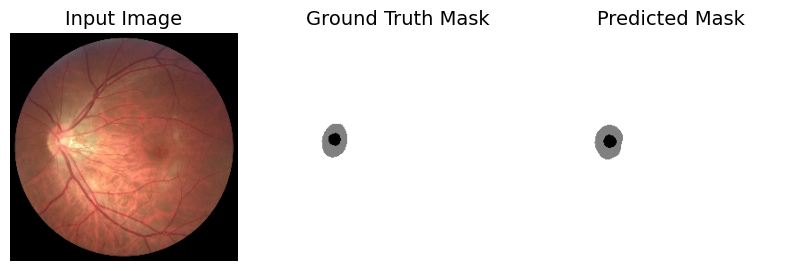

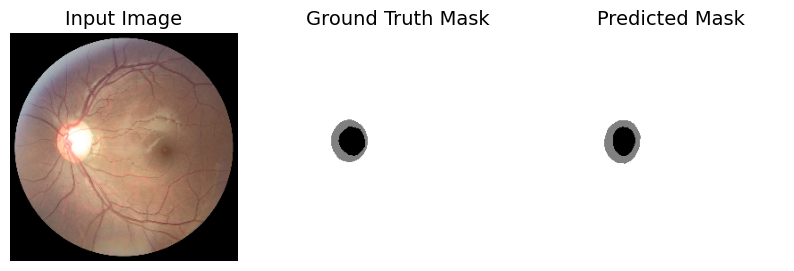

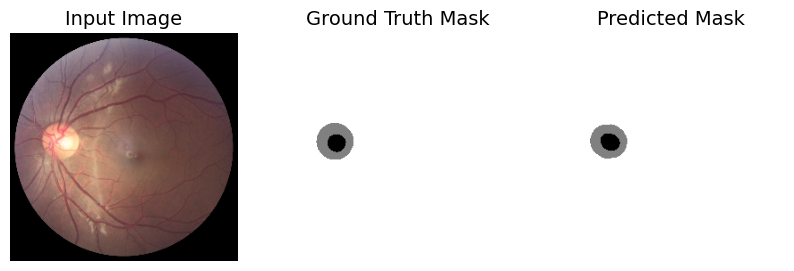

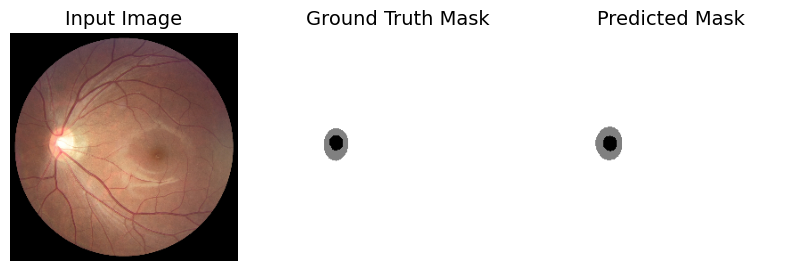

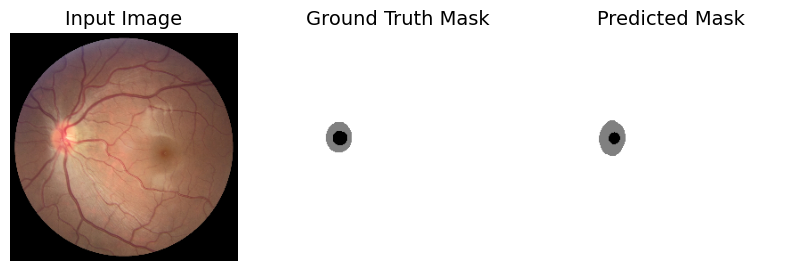

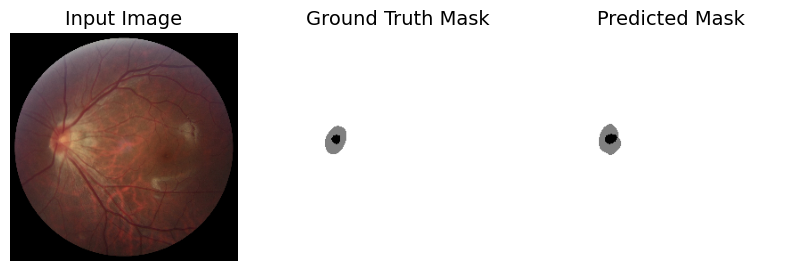

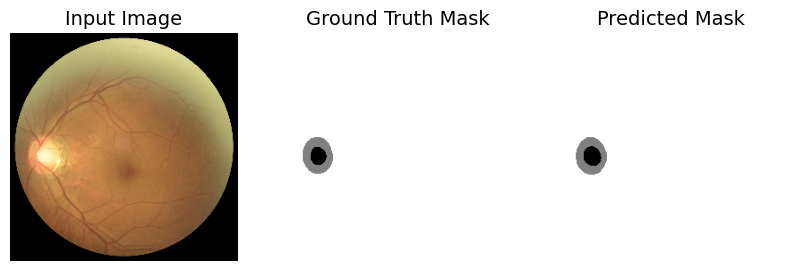

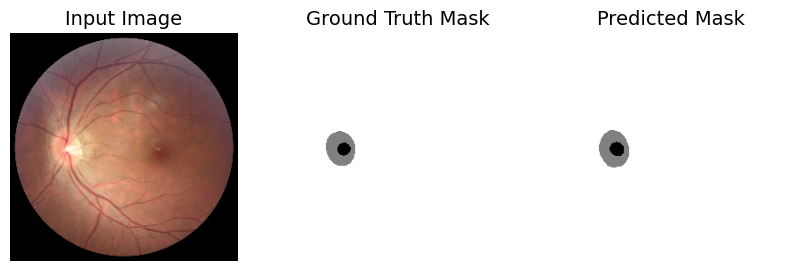

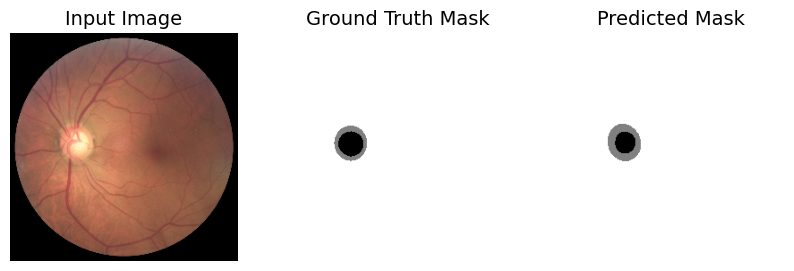

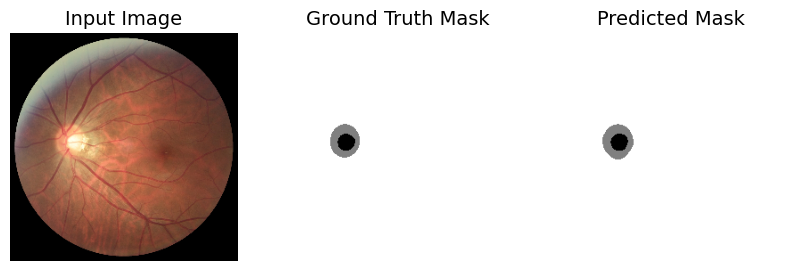

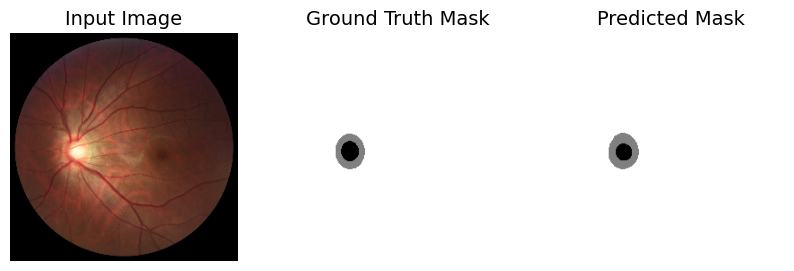

In [109]:
for i in range(0,30):
    plt.figure(figsize=(10,10))
    plt.axis('Off')
    test_image = test_images[i, :, :]
    #test_image = X_test[i, :, :]
    plt.subplot(1,3,1)
    plt.imshow(test_image)
    plt.title('Input Image', fontsize=14)
    plt.axis('off')

    test_mask=test_masks[i,:,:]
    plt.subplot(1,3,2)
    plt.imshow(test_mask, cmap='gray')
    plt.title('Ground Truth Mask', fontsize=14)
    plt.axis('off')

    test_mask = preds_test_thresh[i, :, :]
    plt.subplot(1,3,3)
    plt.imshow(test_mask, cmap='gray')
    plt.title('Predicted Mask', fontsize=14)
    plt.axis('off')
    
    plt.savefig(f'CSP-Res-Seg-Net_{i}.jpg', dpi=1200, bbox_inches='tight')
    